In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

In [2]:
def txt2csv(filename, durations: list, labels: list, save_csv: bool = True, save_dir: str = "./csv"): # filename: *.txt
    # read txt as dataframe
    df = pd.read_csv(filename, sep = '	', header=None)
    df.drop(columns = [0], inplace = True)
    columns = [
        "P51_05", "P51_06", "T51_01", "F51_01", "LC51_03CV", # Actuator01
        "LC51_03X", "LC51_03PV", "TC51_05", "T51_08", "D51_01",
        "D51_02", "F51_02", "PC51_01", "T51_06", "P51_03", "T51_07",
        "P57_03", "P57_04", "T57_03", "FC57_03PV", "FC57_03CV", "FC57_03X", # Actuator02
        "P74_00", "P74_01", "T74_00", "F74_00", "LC74_20CV", "LC74_20X", # Actuator03
        "LC74_20PV", "F74_30", "P74_30", "T74_30"
    ]
    df.columns = columns
    
    # set class label
    class_label = np.zeros((df.shape[0],), dtype = "int8")
    for duration, label in zip(durations, labels):
        class_label[duration[0]: duration[1]] = label

    anomaly_label = np.asarray((class_label != 0), dtype = "int8")
    
    df['fault_label'] = class_label
    df['anomaly_label'] = anomaly_label
    
#     for i in range(6):
#         df[f'spc_label_{i:02}'] = np.ones(len(df))
    
    if save_csv:
        file = filename.split('/')[-1].split('.')[0] + ".csv"
        save_dir += '/'
#         print(save_dir, file)
        df.to_csv(save_dir + file, index = False)
        
    return df

def my_plot(x, Ys, label_lst, title = "", figsize = (16, 9)):
    plt.figure(figsize = figsize, dpi = 100)
    plt.title(title)
    for y, label in zip(Ys, label_lst):
        plt.plot(x, y, label = label)
    plt.legend()
    plt.show()
    
def analysis(file: str, start: int, end: int, columns: list):
    df = pd.read_csv(file)
    Ys = df[columns][start: end].to_numpy().transpose()
    x = np.arange(start, end)
    my_plot(x, Ys, columns, file)

In [33]:
# txt to csv
file = "./raw/30102001.txt"
durations = [
    (58800, 59800),
    (57340, 57890)
]
labels = [18, 18]
df = txt2csv(file, durations, labels)

file = "./raw/09112001.txt"
durations = [
    (57275, 57550),
    (58520, 58625),
    (58830, 59300),
    (60650, 60700),
    (60870, 60960)
]
labels = [16, 18, 18, 16, 16]
df = txt2csv(file, durations, labels)

file = "./raw/17112001.txt"
durations = [
    (54600, 54700),
    (56670, 56770),
    (53780, 53794),
    (54193, 54215),
    (55482, 55517),
    (55977, 56015),
    (57030, 57072),
    (57475, 57530),
    (57675, 57800),
    (58150, 58325),
]
labels = [18, 16, 17, 17, 19, 19, 19, 16, 16, 19]
df = txt2csv(file, durations, labels)

file = "./raw/20112001.txt"
durations = [
    (37780, 38400),
    (44400, None),
]
labels = [17, 17]
df = txt2csv(file, durations, labels)

In [3]:
def dmds_generate_spc_rules(df, target_features, wnd_size=5000):
    df_fe = df[target_features].copy()
    target_feautures = [
        "LC51_03CV", "LC51_03X", "LC51_03PV",
        "P51_06", "T51_01", "F51_01",
        "P57_03", "P57_04", 
        "FC57_03PV", "FC57_03CV", "FC57_03X",
        "F74_00", "LC74_20CV", "LC74_20X",
        "LC74_20PV", 
    ]
    for target in target_features:
        op = "mean"
        df_fe[f"{target}_{op}_{wnd_size}"] = df_fe[target].rolling(wnd_size, min_periods = 200).mean()
    
    for target in target_features:
        op = "std"
        df_fe[f"{target}_{op}_{wnd_size}"] = df_fe[target].rolling(wnd_size, min_periods = 200).std()
    
    df_fe.dropna(axis = 0, inplace = True)
    return df_fe

In [4]:
target_features = [
    "LC51_03CV", "LC51_03X", "LC51_03PV",
    "P51_06", "T51_01", "F51_01",
    "P57_03", "P57_04", 
    "FC57_03PV", "FC57_03CV", "FC57_03X",
    "F74_00", "LC74_20CV", "LC74_20X",
    "LC74_20PV", 
]
wnd_size = 5000

filelst = ["30102001", "09112001", "17112001", "20112001"]
for file in filelst:
    filename = f"./csv/{file}.csv"
    df = pd.read_csv(filename)
    df_fe = dmds_generate_spc_rules(df, target_features, wnd_size)
    df_fe.to_csv(f"./csv_fe/{file}.csv", index = False)

In [10]:
df = pd.read_csv("csv_fe/30102001.csv")
df

,LC51_03CV,LC51_03X,LC51_03PV,P51_06,T51_01,F51_01,P57_03,P57_04,FC57_03PV,FC57_03CV,...,FC57_03X_mean_5000,FC57_03X_std_5000,F74_00_mean_5000,F74_00_std_5000,LC74_20CV_mean_5000,LC74_20CV_std_5000,LC74_20X_mean_5000,LC74_20X_std_5000,LC74_20PV_mean_5000,LC74_20PV_std_5000
0,34.9,35.1,48.8,340.4,96.7,352.3,492.1,169.0,55.3,70.5,...,70.237000,70.237000,17.557000,17.557000,61.516500,61.516500,62.829000,62.829000,49.955000,49.955000
1,35.6,34.4,49.4,346.3,96.7,353.4,492.1,169.2,54.8,70.2,...,70.237811,70.237811,17.577612,17.577612,61.475622,61.475622,62.810945,62.810945,49.953731,49.953731
2,36.2,34.2,49.6,342.6,96.7,355.9,492.3,169.5,55.1,70.1,...,70.240594,70.240594,17.610396,17.610396,61.438119,61.438119,62.769802,62.769802,49.954950,49.954950
3,36.3,34.7,49.8,335.8,96.7,356.9,491.6,169.5,55.3,70.3,...,70.241379,70.241379,17.646798,17.646798,61.427094,61.427094,62.726108,62.726108,49.959113,49.959113
4,36.0,35.6,49.5,338.2,96.7,353.7,490.6,169.2,56.1,70.6,...,70.240686,70.240686,17.660784,17.660784,61.424510,61.424510,62.707353,62.707353,49.967157,49.967157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86196,49.4,48.1,48.6,253.2,96.1,266.8,528.0,169.0,30.0,81.0,...,81.591720,81.591720,14.487160,14.487160,66.484100,66.484100,67.442420,67.442420,49.219800,49.219800
86197,49.4,48.7,48.7,253.2,96.1,266.7,528.0,169.5,30.0,81.1,...,81.591500,81.591500,14.482780,14.482780,66.488880,66.488880,67.448520,67.448520,49.219780,49.219780
86198,49.7,48.9,49.0,255.9,96.1,267.0,528.7,169.0,30.4,81.2,...,81.591320,81.591320,14.479280,14.479280,66.492340,66.492340,67.453920,67.453920,49.219900,49.219900
86199,50.0,49.5,49.2,251.8,96.1,267.2,526.7,168.7,30.2,81.4,...,81.591220,81.591220,14.476740,14.476740,66.495800,66.495800,67.458240,67.458240,49.219860,49.219860


## EDA

In [3]:
filename = "./csv/20112001.csv"
df = pd.read_csv(filename)

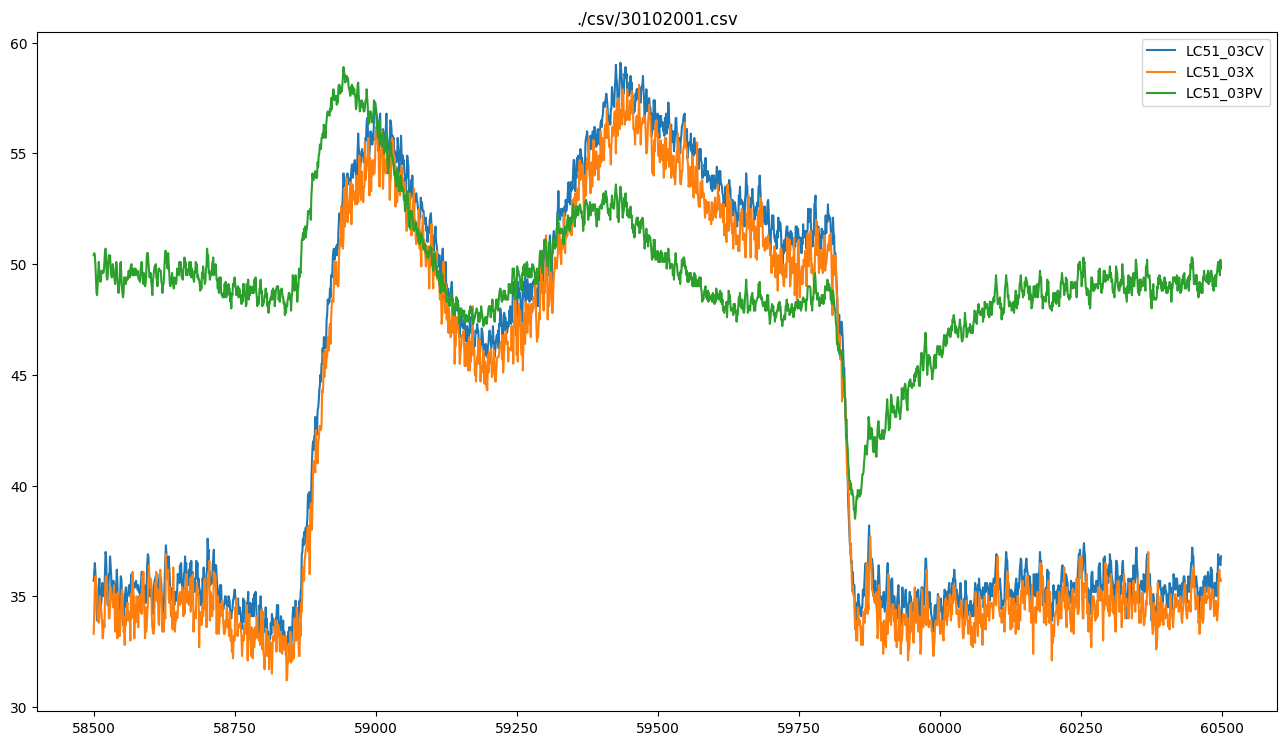

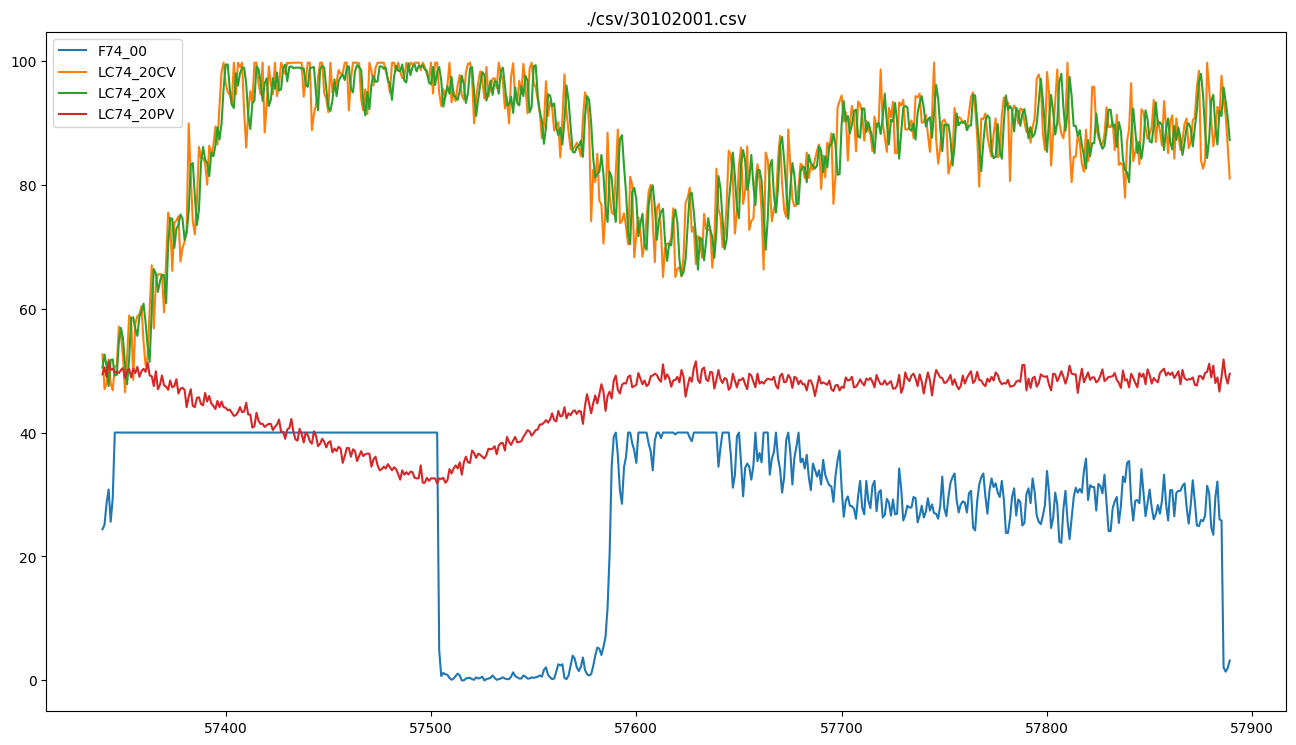

In [20]:
# fault in 30102001.csv
file = "./csv/30102001.csv"
start, end = 58500, 60500
col_lst = ["LC51_03CV", "LC51_03X", "LC51_03PV"]
analysis(file, start, end, col_lst)



start, end = 57340, 57890
col_lst = ["F74_00", "LC74_20CV", "LC74_20X", "LC74_20PV"]
analysis(file, start, end, col_lst)

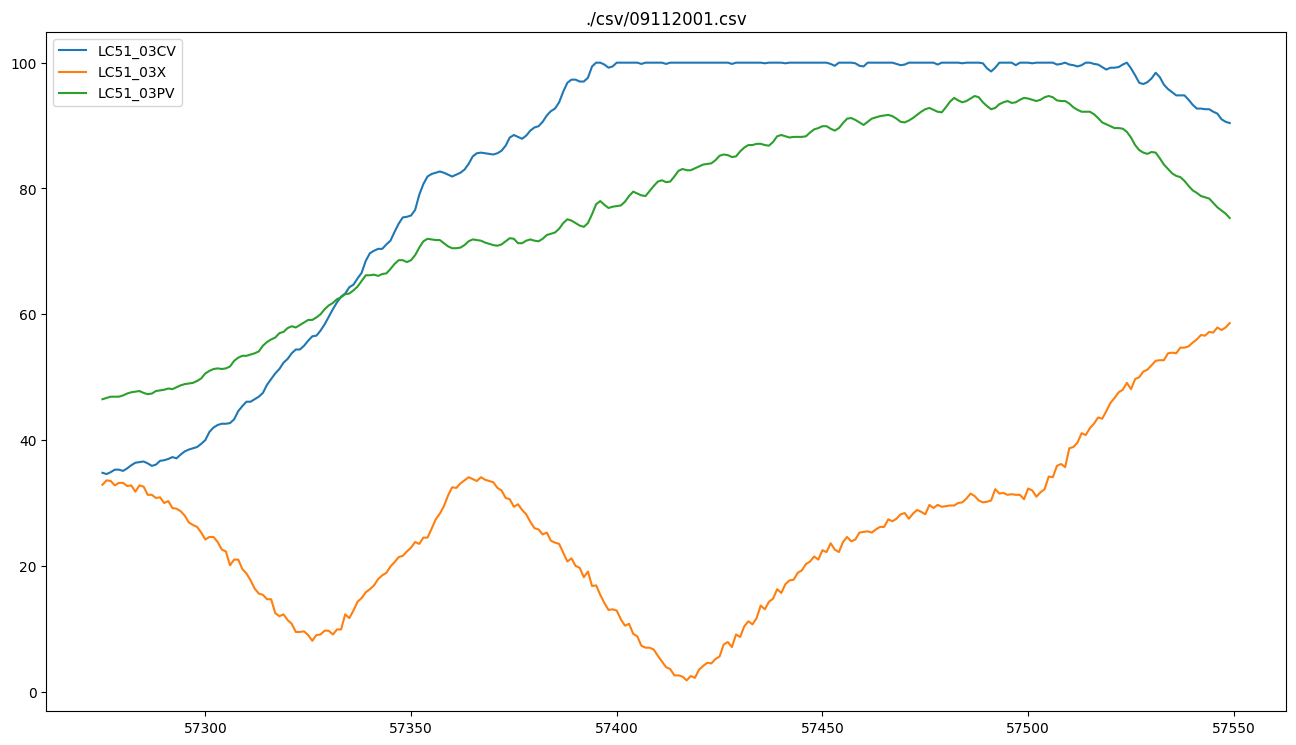

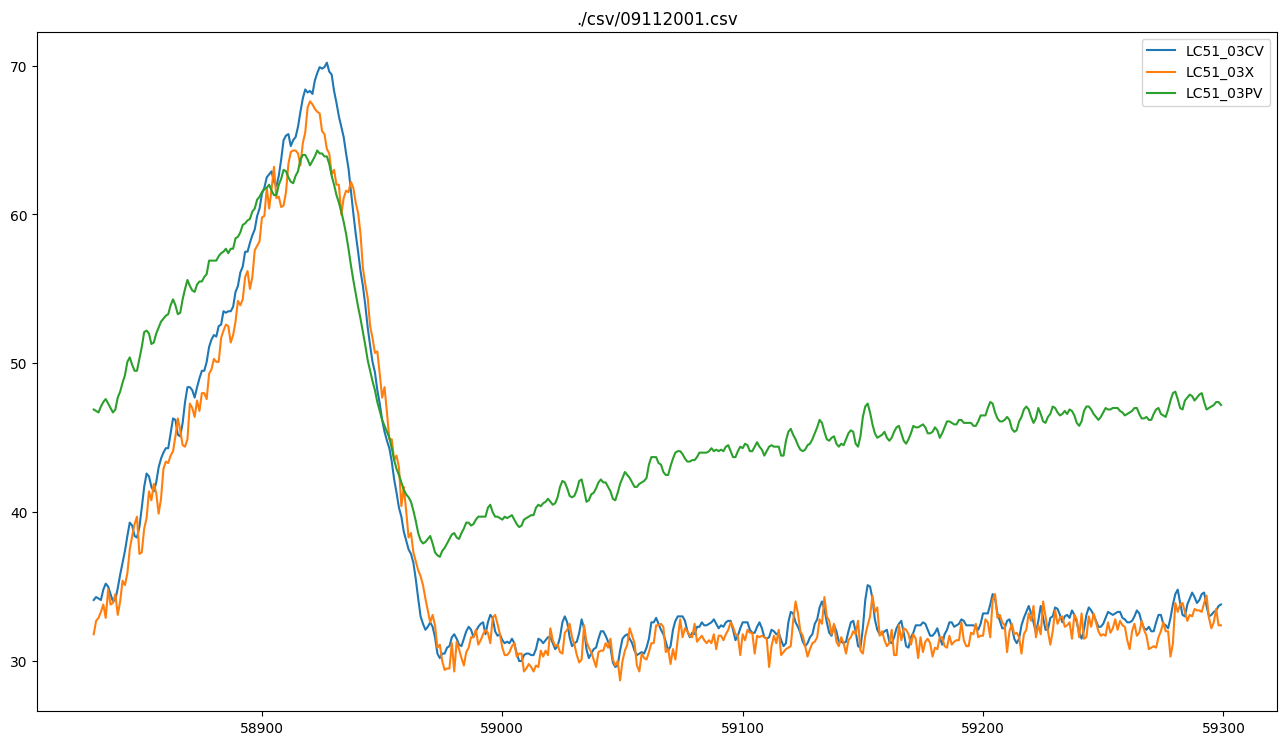

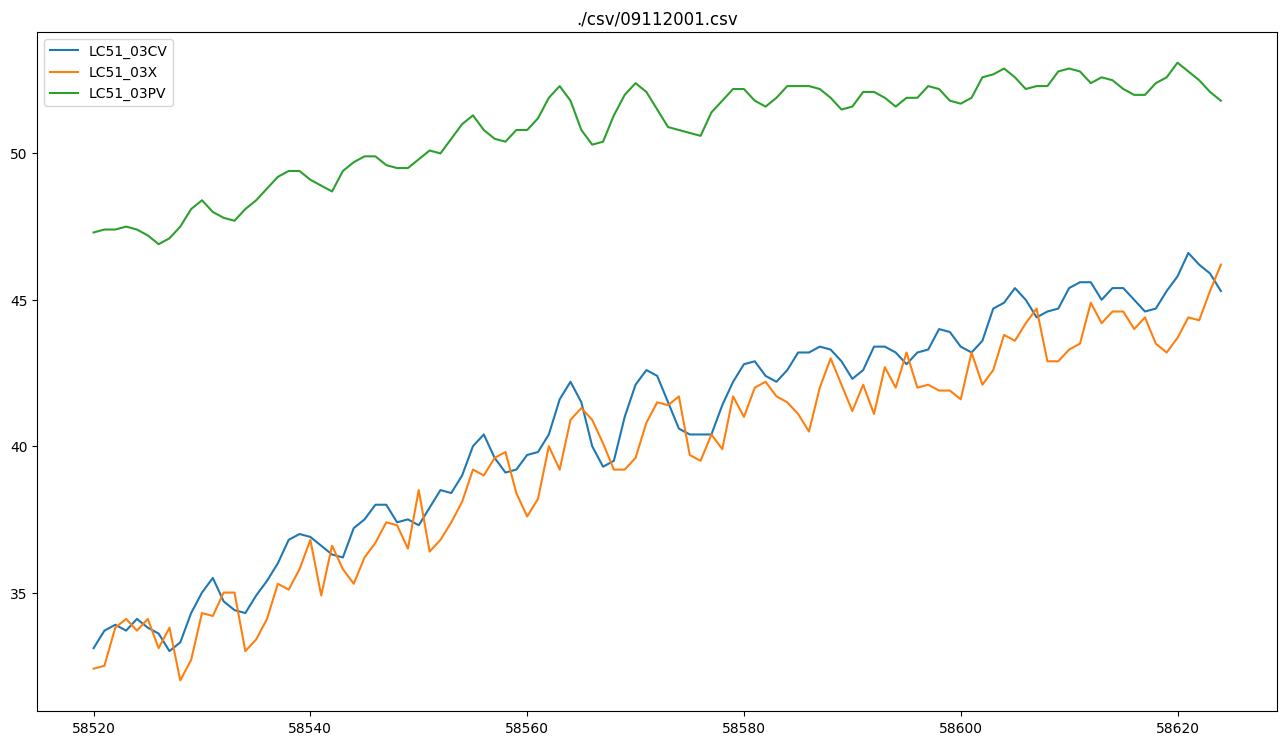

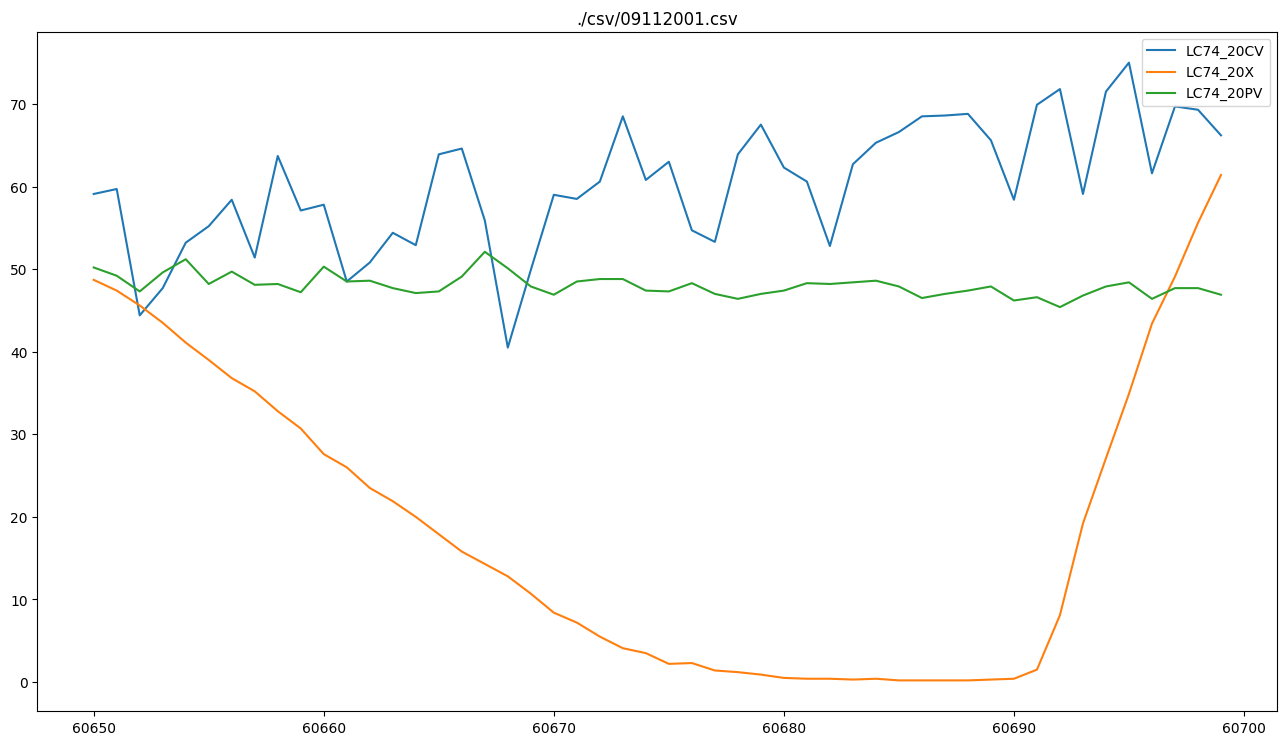

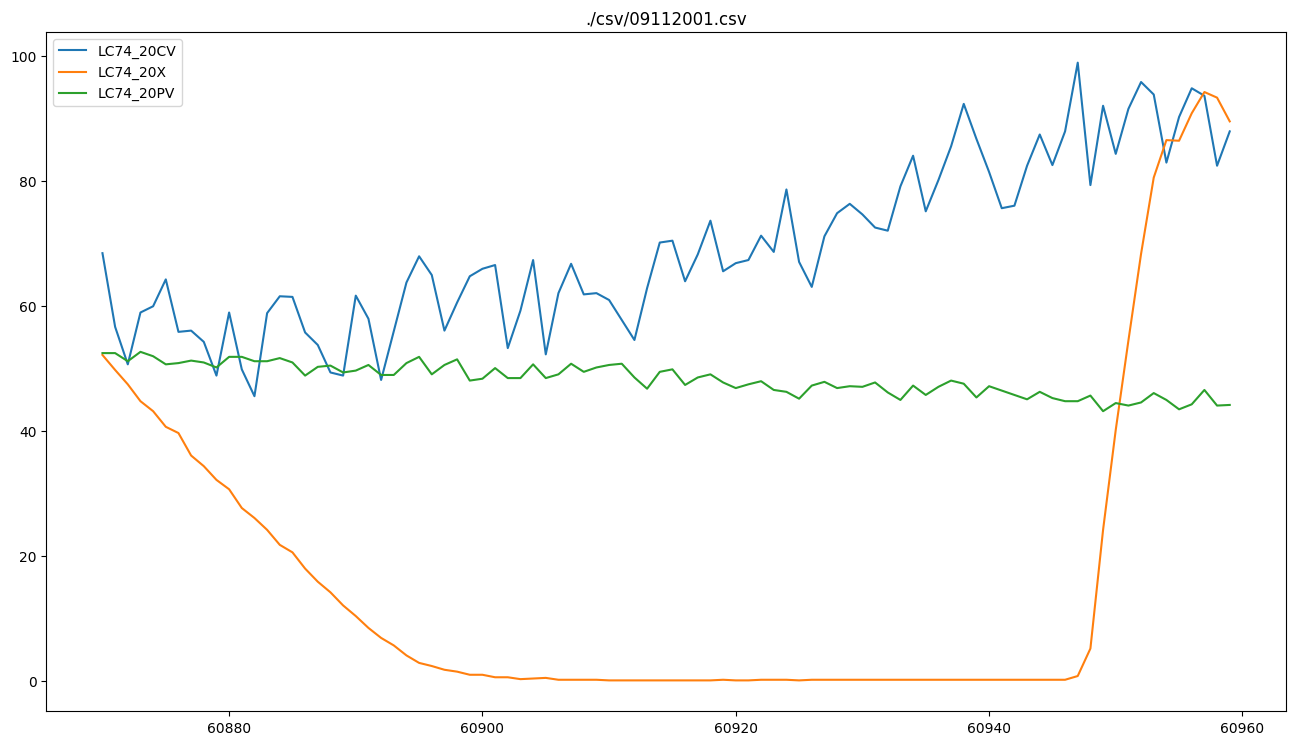

In [19]:
# fault in 09112001.csv
file = "./csv/09112001.csv"
start, end = 57275, 57550
col_lst = ["LC51_03CV", "LC51_03X", "LC51_03PV"]
analysis(file, start, end, col_lst)

start, end = 58830, 59300
analysis(file, start, end, col_lst)

start, end = 58520, 58625
analysis(file, start, end, col_lst)

start, end = 60650, 60700
col_lst = ["LC74_20CV", "LC74_20X", "LC74_20PV"]
analysis(file, start, end, col_lst)

start, end = 60870, 60960
analysis(file, start, end, col_lst)

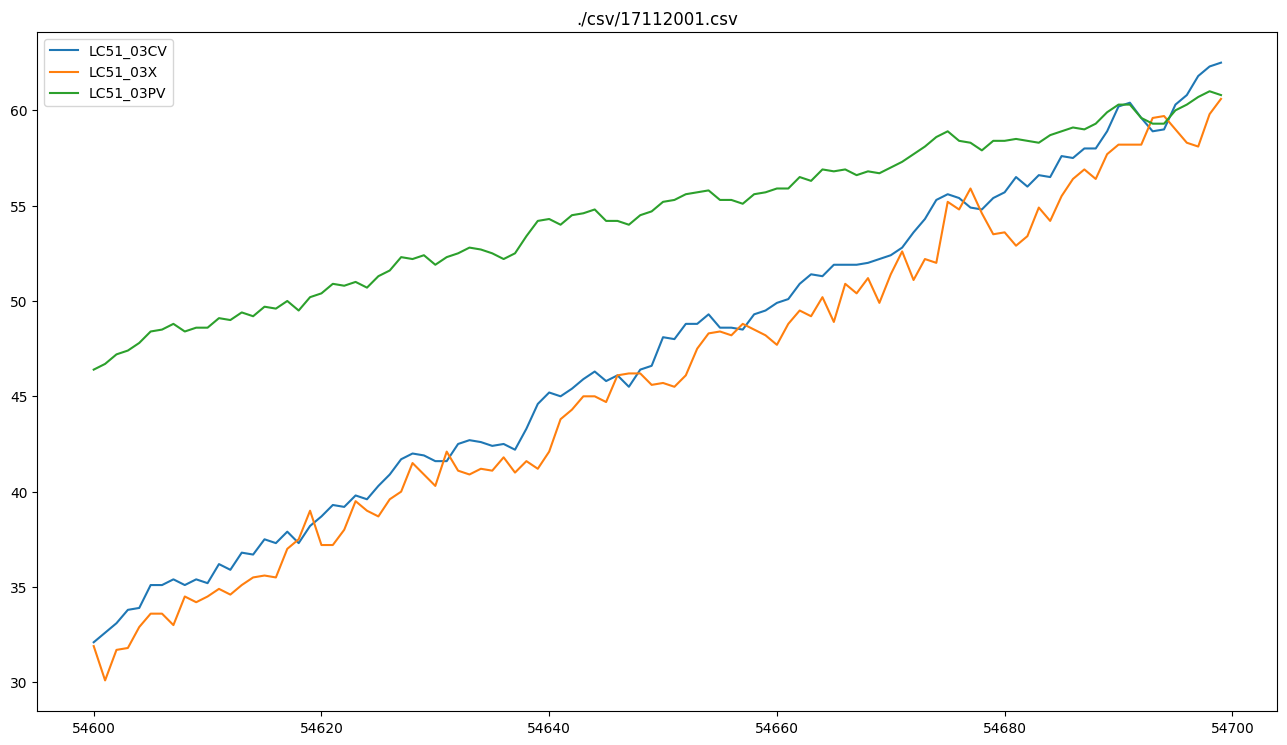

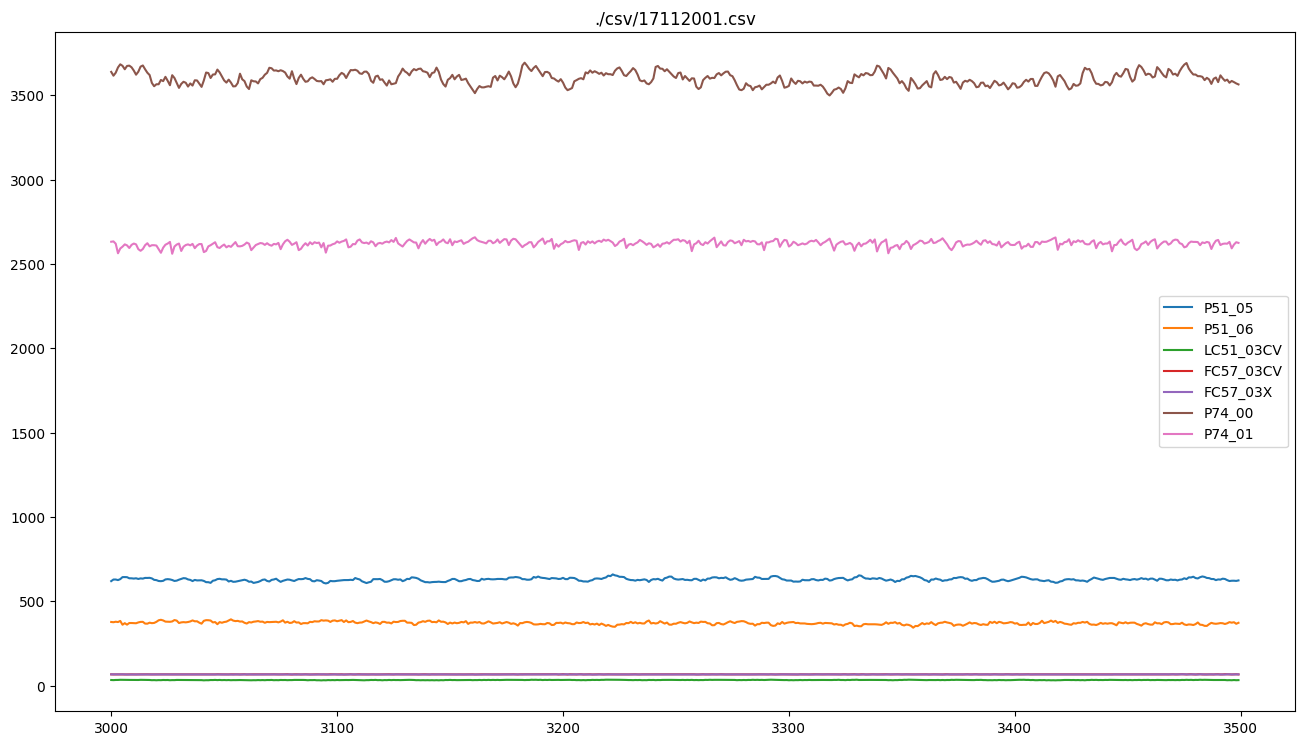

In [4]:
# fault in 171122001.csv
start, end = 54600, 54700
file = "./csv/17112001.csv"
col_lst = ["LC51_03CV", "LC51_03X", "LC51_03PV"]
analysis(file, start, end, col_lst)

start, end = 3000, 3500
col_lst = [
    "P51_05", "P51_06", "LC51_03CV", # Actuator01
    "FC57_03CV", "FC57_03X", # Actuator02
    "P74_00", "P74_01", 
]
analysis(file, start, end, col_lst)

# start, end = 56670, 56770
# analysis(file, start, end, col_lst)

# start, end = 37780, 58400
# col_lst = ["P51_06", "T51_01", "F51_01"]
# analysis(file, start, end, col_lst)



## Test TSAnomalyDataset

In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../../")
from ts_transformers.data import TSAnomalyDataset, TSAnomalyConfig
from ts_transformers.data import SPCAnomalyDataset, SPCAnomalyConfig

In [ ]:
# test TSAnomalyDataset (base dataset)
config = TSAnomalyConfig(
    target_col="anomaly_label",
    window_size=256,
)

filepath = "./csv/17112001.csv"
df = pd.read_csv(filepath)
ts_dataset = TSAnomalyDataset(df, config)

x, y = ts_dataset[0]
print(x.shape, y.shape)

# test SPCDataset (derived class)
config = SPCAnomalyConfig(
    spc_col="fault_label",
    target_col="anomaly_label",
    window_size=256,
)
spc_dataset = SPCAnomalyDataset(df, config)

x, spc, y = spc_dataset[0]
print(x.shape, spc.shape, y.shape)

In [18]:
target = '09112001.csv'
df = pd.read_csv(f'csv/{target}')
df

,P51_05,P51_06,T51_01,F51_01,LC51_03CV,LC51_03X,LC51_03PV,TC51_05,T51_08,D51_01,...,P74_30,T74_30,fault_label,anomaly_label,spc_label_00,spc_label_01,spc_label_02,spc_label_03,spc_label_04,spc_label_05
0,699.1,300.6,97.8,296.2,42.7,42.0,46.1,129.1,133.4,12.2,...,2369.7,374.7,0,0,1.0,1.0,1.0,1.0,1.0,1.0
1,697.7,298.9,97.8,295.4,41.8,41.6,45.3,129.1,133.3,12.2,...,2370.7,374.9,0,0,1.0,1.0,1.0,1.0,1.0,1.0
2,696.2,301.8,97.8,295.4,42.9,41.4,46.6,129.1,133.4,12.2,...,2371.7,374.7,0,0,1.0,1.0,1.0,1.0,1.0,1.0
3,702.8,300.9,97.7,295.1,43.1,41.5,46.0,129.1,133.4,12.2,...,2372.6,374.7,0,0,1.0,1.0,1.0,1.0,1.0,1.0
4,701.3,292.6,97.8,294.6,42.6,42.3,47.0,129.1,133.4,12.2,...,2370.7,374.6,0,0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,598.8,373.1,97.0,379.9,31.4,30.0,46.9,128.7,132.3,13.5,...,2401.0,396.5,0,0,1.0,1.0,1.0,1.0,1.0,1.0
86396,601.5,365.6,97.0,378.9,30.7,30.7,46.4,128.7,132.3,13.5,...,2401.0,396.5,0,0,1.0,1.0,1.0,1.0,1.0,1.0
86397,597.8,374.8,97.0,378.5,30.1,30.5,46.4,128.7,132.3,13.5,...,2401.0,396.6,0,0,1.0,1.0,1.0,1.0,1.0,1.0
86398,593.7,379.7,97.0,378.8,30.3,30.3,46.1,128.7,132.3,13.5,...,2401.0,396.6,0,0,1.0,1.0,1.0,1.0,1.0,1.0


In [1]:
import torch

In [7]:
batch, seq, dim = 3, 100, 33
a = torch.tensor([1, 0, 1])
b = torch.rand(batch, seq, dim)
c = b[a == 2]
print(a.shape, b.shape, c.shape)

torch.Size([3]) torch.Size([3, 100, 33]) torch.Size([0, 100, 33])


In [16]:
mean = torch.mean(b[0], dim = 1)
mean.shape

torch.Size([100])

In [17]:
b[0].shape

torch.Size([100, 33])

## ML anomaly detection

In [19]:
import pandas as pd
import numpy as np

# train: 09112001.csv
# test: 17112001.csv
train_file = "09112001.csv"
test_file = "17112001.csv"
train_df = pd.read_csv(f'csv/{train_file}')
test_df = pd.read_csv(f'csv/{test_file}')

drop_cols = [f"spc_label_{i:02}" for i in range(6)] + ["fault_label", "anomaly_label"]
y_train = np.array(train_df["anomaly_label"])
x_train = np.array(train_df.drop(columns = drop_cols))
y_test = np.array(test_df["anomaly_label"])
x_test = np.array(test_df.drop(columns = drop_cols))

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(86400, 32) (86400, 32) (86400,) (86400,)


In [32]:
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

IF = IsolationForest(
    n_estimators=70,
    max_features=0.8,
    contamination=0.3#706/86400
)
IF.fit(x_train)
pred = IF.predict(x_test)
pred[pred == -1] = 0
result = classification_report(y_test, pred)
print(result)

# RF = RandomForestClassifier(class_weight = "balanced")
# RF.fit(x_train, y_train)
# pred = RF.predict(x_train)
# result = classification_report(y_train, pred)
# print(result)

# pred = RF.predict(x_test)
# result = classification_report(y_test, pred)
# print(result)

              precision    recall  f1-score   support

           0       0.99      0.87      0.92     85694
           1       0.00      0.00      0.00       706

    accuracy                           0.86     86400
   macro avg       0.50      0.43      0.46     86400
weighted avg       0.98      0.86      0.92     86400



In [ ]:
OCS = OneClassSVM()
OCS.fit(x_train)
pred = OCS.predict(x_test)
pred[pred == -1] = 0
result = classification_report(y_test, pred)
print(result)